<a href="https://colab.research.google.com/github/srilamaiti/spring_2023_w266_final_project_heesuk_iris_srila/blob/main/srila/bertweet_ell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing new libraries**

In [1]:
!pip install nltk
!pip install wordcloud
!pip install transformers
!pip install emoji==0.6.0
!pip3 install tokenizers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49732 sha256=a66c97d8b082e87f5f21e0a11c225ff70f1c9806dee86cbca305d518c2f301c9
  Stored in directory: /root/.cache/pip/wheels/70/2a/7f/1a0012c86b1061c6ee2ed9568b1f830f857a51e8

# **Importing libraries**

In [2]:
import transformers
print(f'transformers version: {transformers.__version__}')
from transformers import logging as hf_logging
from transformers import BertTokenizer, TFBertModel
from transformers import TFAutoModel, AutoTokenizer
hf_logging.set_verbosity_error()
import nltk
from nltk.tokenize import sent_tokenize
import spacy      
from spacy import displacy
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
nltk.download('punkt')

# Other required libraries
import os
import pandas as pd
import numpy as np
import re
import copy
import sys
import gc
import warnings
warnings.filterwarnings("ignore")

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import mae
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from keras.models import load_model

import torch
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

transformers version: 4.27.3


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **General functions**

## **Set parameters**

In [3]:
def set_config_param(seed = 99):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.backend.clear_session()
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_columns', None)
    
    
set_config_param(20230214)

## **Plot loss and accuracy**

In [4]:
def plot_loss_accuracy(history, col_list):
    fig, ax = plt.subplots(2, 6, figsize=(16, 6), sharex='col', sharey='row')
    fig.tight_layout(pad=5.0)
    for idx, col in enumerate(col_list):

        ax[0, idx].plot(history[col + '_loss'], lw=2, color='darkgoldenrod')
        ax[0, idx].plot(history['val_' + col + '_loss'], lw=2, color='indianred')
        #ax[0, idx].legend(loc='center left')
        ax[0, idx].legend(['Train', 'Validation'], fontsize=5)
        ax[0, idx].set_xlabel('Epochs', size=10)
        ax[0, idx].set_title('Loss: ' + col)

        ax[1, idx].plot(history[col + '_accuracy'], lw=2, color='darkgoldenrod')
        ax[1, idx].plot(history['val_' + col + '_accuracy'], lw=2, color='indianred')
        #ax[0, idx].legend(loc='center left')
        ax[1, idx].legend(['Train', 'Validation'], fontsize=5)
        ax[1, idx].set_xlabel('Epochs', size=10)
        ax[1, idx].set_title('Accuracy: ' + col)

## **Custom metric**

In [5]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1, keepdims=True)

In [6]:
def MCRMSE(y_preds, y_trues):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False)
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores


def get_score(y_trues, y_preds):
    mcrmse_score, scores = MCRMSE(y_trues, y_preds)
    return mcrmse_score, scores

def loss_fn(outputs, targets):
    loss_fn = torch.nn.MSELoss()
    loss = torch.sqrt(loss_fn(outputs, targets))
    return loss

# **Read input files**

In [7]:
input_train_df = pd.read_csv('train.csv')
input_test_df = pd.read_csv('test.csv')
label_cols = input_train_df.columns[2:]
orig_train_df = copy.deepcopy(input_train_df)
orig_train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


# **Spliting the data**
Original test data is very limited, there are only 3 records and it does not have labels to test. So we decided to repurpose the given train data to split into train, test and validation sets.

In [8]:
shuffle = np.random.permutation(np.arange(orig_train_df.shape[0]))
orig_train_df = orig_train_df.iloc[shuffle]
split=(0.8,0.1,0.1)
splits = np.multiply(len(orig_train_df), split).astype(int)
df_train, df_val, df_test = np.split(orig_train_df, [splits[0], splits[0] + splits[1]])

X_train, X_val, X_test = df_train['full_text'], df_val['full_text'], df_test['full_text']
y_train, y_val, y_test = np.array(df_train[label_cols]), np.array(df_val[label_cols]), np.array(df_test[label_cols])

# **Model building**

In [9]:
set_config_param()
MAX_LENGTH = 512
epochs = 5
batch_size = 8
dropout = .1
learning_rate = .00005
number_of_hidden_layer = 1
hidden_layer_node_count = 64
trainable_flag = False
retrain_layer_count = 0

In [82]:
bertweet_model_checkpoint = 'vinai/bertweet-base'   
bertweet_model = TFAutoModel.from_pretrained(bertweet_model_checkpoint)
bertweet_tokenizer = AutoTokenizer.from_pretrained(bertweet_model_checkpoint, use_fast=False, normalization = True)

In [83]:
def encode_text(text, tokenizer):
    
    encoded = tokenizer.batch_encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors="tf",
    )

    input_ids = np.array(encoded["input_ids"], dtype="int32")
    attention_masks = np.array(encoded["attention_mask"], dtype="int32")

    return {
        "input_ids": input_ids,
        "attention_masks": attention_masks
    }

In [84]:
input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='input_ids_layer')
attention_mask = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='attention_mask_layer')
#segment_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name="segment_id_layer")

In [85]:
train_encodings = encode_text(df_train['full_text'].tolist(), bertweet_tokenizer)
val_encodings = encode_text(df_val['full_text'].tolist(), bertweet_tokenizer)
test_encodings = encode_text(df_test['full_text'].tolist(), bertweet_tokenizer)

In [86]:
train_encodings

{'input_ids': array([[    0, 16017, 19819, ...,     1,     1,     1],
        [    0,     8,   101, ...,     1,     1,     1],
        [    0,     8,  5766, ...,     1,     1,     1],
        ...,
        [    0,   726,  2522, ...,     9,  6553,     2],
        [    0,  1038,    14, ...,     1,     1,     1],
        [    0,  2420,    83, ...,   153,    15,     2]], dtype=int32),
 'attention_masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1]], dtype=int32)}

In [87]:
train_encodings.keys()

dict_keys(['input_ids', 'attention_masks'])

In [88]:
bertweet_model

In [89]:
bertweet_model.summary()

Model: "tf_roberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 134899968 
 )                                                               
                                                                 
Total params: 134,899,968
Trainable params: 134,899,968
Non-trainable params: 0
_________________________________________________________________


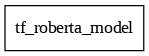

In [90]:
keras.utils.plot_model(bertweet_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [91]:
bertweet_model_v1 = bertweet_model(input_ids, attention_mask=attention_mask)
cls_token = bertweet_model_v1[0][:, 0, :]

In [92]:
bertweet_model_v1

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<KerasTensor: shape=(None, 512, 768) dtype=float32 (created by layer 'tf_roberta_model')>, pooler_output=<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_roberta_model')>, past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)

In [93]:
list(bertweet_model_v1)

['last_hidden_state', 'pooler_output']

In [94]:
cls_token

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [96]:
layer_list = []
for hidden_layer_number in range(number_of_hidden_layer):
    if hidden_layer_number == 0:
        hidden_layer = tf.keras.layers.Dense(units = hidden_layer_node_count
                                    , activation = 'relu'
                                    , name = 'hidden_layer_' + str(hidden_layer_number + 1)
                                     )(cls_token)
    else:
        hidden_layer = tf.keras.layers.Dense(units = hidden_layer_node_count
                                    , activation = 'relu'
                                    , name = 'hidden_layer_' + str(hidden_layer_number + 1)
                                     )(layer_list[-1])
    layer_list.append(hidden_layer)
    dropout_layer = tf.keras.layers.Dropout(dropout, name = 'dropout_layer_' + str(hidden_layer_number + 1))(hidden_layer) 
    layer_list.append(dropout_layer)
#layer_list.append(tf.keras.layers.Flatten()) 

In [100]:
output = tf.keras.layers.Dense(6,)(layer_list[-1])
bertweet_v1_regression_model = tf.keras.Model(inputs = [input_ids, 
                                                        attention_mask
                                                       ], 
                                                       outputs = output
                                             )

bertweet_v1_regression_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
                                     loss = MCRMSE,
                                     metrics=MCRMSE
                                    ) 
print(bertweet_v1_regression_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134899968  ['input_ids_layer[0][0]',        
 el)                            thPoolingAndCrossAt               'attention_mask_layer[0][0]']   
                                tentions(last_hidde                                         

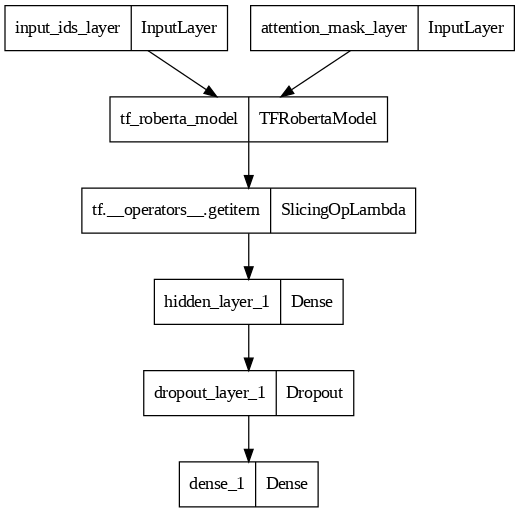

In [101]:
keras.utils.plot_model(bertweet_v1_regression_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [102]:
bertweet_v1_regression_model_history = bertweet_v1_regression_model.fit([train_encodings['input_ids'], 
                                                                         train_encodings['attention_masks']
                                                                        ], 
                                                                        y_train,   
                                                                        validation_data =([val_encodings['input_ids'], 
                                                                                           val_encodings['attention_masks']
                                                                                          ], 
                                                                                          y_val
                                                                                         ),    
                                                                        batch_size = batch_size, 
                                                                        epochs = epochs
                                                                       )                                                  
bertweet_v1_regression_model_history_df = pd.DataFrame(bertweet_v1_regression_model_history.history)
bertweet_v1_regression_model_history_df.T

Epoch 1/5


InvalidArgumentError: ignored

In [ ]:
score_bertweet_v1_regression_model = bertweet_v1_regression_model.evaluate([test_encodings.input_ids, 
                                                                            test_encodings.attention_mask
                                                                           ], 
                                                                           y_test
                                                                          ) 

print(score_bertweet_v1_regression_model)

In [ ]:
predictions_bertweet_v1_regression_model = bertweet_v1_regression_model.predict([test_encodings.input_ids, 
                                                                                 test_encodings.attention_mask
                                                                                ]
                                                                               )
print(predictions_bertweet_v1_regression_model)

In [ ]:
df_test[label_cols]

In [ ]:
predictions_bertweet_v1_regression_model

In [ ]:
x_arr = np.arange(len(bertweet_v1_regression_model['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, bertweet_v1_regression_model_history_df['loss'], '-o', label='Train loss')
ax.plot(x_arr, bertweet_v1_regression_model_history_df['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, bertweet_v1_regression_model_history_df['MCRMSE'], '-o', label='Train MCRMSE')
ax.plot(x_arr, bertweet_v1_regression_model_history_df['val_MCRMSE'], '--<', label='Validation MCRMSE')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

In [ ]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer


tokenizer = TweetTokenizer()


def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token

'''
https://preply.com/en/blog/the-most-used-internet-abbreviations-for-texting-and-tweeting/
'''
def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
        .replace("bc", "because")
        .replace("btw", "by the way")
        .replace("cya", "see ya")
        .replace(" u ", " you ")
        .replace("dm", "direct message")
        .replace("gm", "good morning")
        .replace("ftw", "for the win")
        .replace("tbh", "to be honest")
        .replace("fwiw", "for what it’s worth")
        .replace("idk", "I don't know")
        .replace("ily", "I love you")
        .replace("brb", "be right back")
        .replace("imo", "in my opinion")
        .replace("irl", "in real life")
        .replace("jk", "just kidding")
        .replace("lmk", "let me know")
        .replace("lmc", "let me check")
        .replace("lol", "laughing out loud")
        .replace("nbd", "no big deal")
        .replace("np", "no problem")
        .replace("wc", "welcome")
        .replace("nsfw", "not safe for work")
        .replace("nvm", "never mind")
        .replace("omg", "oh my god")
        .replace("otoh", "on the other hand")
        .replace("omw", "on my way")
        .replace("rofl", "rolling on floor laughing")
        .replace("SO", "significant other")
        .replace("thx", "thanks")
        .replace("tmi", "too much information")
        .replace("ttyl", "talk to you later")
        .replace("fwiw", "for what it’s worth")
        .replace("yolo", "you only live once")
        .replace("tldr", "too long, didn't read")
        .replace("asap", "as soon as possible")
        .replace("bau", "business as usual")
        .replace("fyi", "for your information")
        .replace("fyip", "for your information please")
        .replace("fya", "for your action")
        .replace("fyap", "for your action please")
        .replace("msg", "message")
        .replace("fb", "facebook")
        .replace("txt", "text")
        .replace("gtg", "got to go")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())

In [ ]:
'''
import torch
from transformers import AutoTokenizer
#from TweetNormalizer import normalizeTweet

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large")

line = normalizeTweet("DHEC confirms https://postandcourier.com/health/covid19/sc-has-first-two-presumptive-cases-of-coronavirus-dhec-confirms/article_bddfe4ae-5fd3-11ea-9ce4-5f495366cee6.html?utm_medium=social&utm_source=twitter&utm_campaign=user-share… via @postandcourier 😢")

input_ids = torch.tensor([tokenizer.encode(line)])
input_ids
'''

https://colab.research.google.com/github/devhemza/BERTweet_sentiment_analysis/blob/main/BERTweet.ipynb#scrollTo=KrZkll3WI1jF

In [112]:
loss = tf.keras.losses.mse
metrics=tf.keras.metrics.mse
x = bertweet_model_v1[1]
x = tf.keras.layers.Dense(6,activation='sigmoid')(x)
output = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x)
model = tf.keras.models.Model(inputs = [input_ids,attention_mask],outputs = output)
model.compile(tf.keras.optimizers.Adam(learning_rate), loss=loss,metrics=metrics)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134899968  ['input_ids_layer[0][0]',        
 el)                            thPoolingAndCrossAt               'attention_mask_layer[0][0]']   
                                tentions(last_hidde                                         

In [113]:
history = model.fit([train_encodings['input_ids'], 
                                                                         train_encodings['attention_masks']
                                                                        ], 
                                                                        y_train,   
                                                                        validation_data =([val_encodings['input_ids'], 
                                                                                           val_encodings['attention_masks']
                                                                                          ], 
                                                                                          y_val
                                                                                         ),    
                                                                        batch_size = batch_size, 
                                                                        epochs = epochs
                                                                       )

Epoch 1/5


InvalidArgumentError: ignored

In [35]:
col = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
targets = np.array(df_train[col], dtype="float32")

MAX_LEN = 512

def bert_encode(texts, tokenizer, max_len):
    input_ids = []
    # token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(text, max_length=max_len, truncation=True, padding='max_length',
                         add_special_tokens=True)
        input_ids.append(token['input_ids'])
        # token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(attention_mask)

from transformers import RobertaTokenizer, TFRobertaModel

ROBERTA_MODEL = "roberta-base"

bert_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL)
bert_model = TFRobertaModel.from_pretrained(ROBERTA_MODEL)

train_input_ids,train_attention_masks = bert_encode(df_train['full_text'], bert_tokenizer, MAX_LEN)
loss = tf.keras.losses.mae
metrics=tf.keras.metrics.mae


def build_model(model_layer, learning_rate, dense_dim = 6):
    
    #define inputs
    input_ids = tf.keras.Input(shape=(MAX_LEN ,),dtype='int64')
    attention_masks = tf.keras.Input(shape=(MAX_LEN ,),dtype='int64')
 
    
    #insert BERT layer
    transformer_layer = model_layer([input_ids,attention_masks])
    
    #choose only last hidden-state
    x = transformer_layer[1]
    x = tf.keras.layers.Dense(dense_dim,activation='sigmoid')(x)
    output = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)

    model.compile(tf.keras.optimizers.Adam(learning_rate), loss=loss,metrics=metrics)
    
    return model

BERT= build_model(bert_model,learning_rate=1e-5)
BERT.summary()

history = BERT.fit((train_input_ids,train_attention_masks),targets,batch_size =4,        
                epochs=2,
                validation_split = 0.2
                )



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_roberta_model_3 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 odel)                          thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

In [ ]:
col = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
targets = np.array(df_train[col], dtype="float32")

MAX_LEN = 512

def bert_encode(texts, tokenizer, max_len):
    input_ids = []
    # token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(text, max_length=max_len, truncation=True, padding='max_length',
                         add_special_tokens=True)
        input_ids.append(token['input_ids'])
        # token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(attention_mask)

from transformers import RobertaTokenizer, TFRobertaModel

ROBERTA_MODEL = "roberta-base"

roberta_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL)
roberta_model = TFRobertaModel.from_pretrained(ROBERTA_MODEL)

train_input_ids,train_attention_masks = bert_encode(df_train['full_text'], bert_tokenizer, MAX_LEN)
loss = tf.keras.losses.mse
metrics=tf.keras.metrics.mse


def build_model(model_layer, learning_rate, dense_dim = 6):
    
    #define inputs
    input_ids = tf.keras.Input(shape=(MAX_LEN ,),dtype='int64')
    attention_masks = tf.keras.Input(shape=(MAX_LEN ,),dtype='int64')
 
    
    #insert BERT layer
    transformer_layer = model_layer([input_ids,attention_masks])
    
    #choose only last hidden-state
    x = transformer_layer[1]
    x = tf.keras.layers.Dense(dense_dim,activation=None)(x)
    output = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)

    model.compile(tf.keras.optimizers.Adam(learning_rate), loss=loss,metrics=metrics)
    
    return model

ROBERTA= build_model(roberta_model,learning_rate=1e-5)
ROBERTA.summary()
print(keras.utils.plot_model(ROBERTA, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90))
history = ROBERTA.fit((train_input_ids,train_attention_masks),
                       targets,
                       batch_size =8,        
                       epochs=5,
                       validation_split = 0.2
                      )



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_roberta_model_4 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_3[0][0]',                
 odel)                          thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         